In [1]:
!pip install transformers datasets torch
!pip install datasets
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.1 MB/s eta 0:00:00


In [2]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-large-uncased")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-large-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at google-bert/bert-large-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dens

In [3]:
import json
from datasets import load_dataset

ds = load_dataset("zeroshot/twitter-financial-news-sentiment")

# System message setting
system_message = "You are a helpful assistant that analyzes economic news for market signals. 0 represents a neutral market, 1 represents a bull market, and 2 represents a bear market."

# Write the data to a JSONL file
with open("data.jsonl", "w") as f:
    for example in ds['train']:
        label = example['label']
        text = example['text']

        # Construct message format
        messages = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
            {"role": "assistant", "content": str(label)}  # Respond with only the label number
        ]

        # Create a JSONL-compatible dictionary
        json_line = {
            "messages": messages
        }

        # Write each line as a JSON object
        f.write(json.dumps(json_line) + "\n")


README.md:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

sent_train.csv:   0%|          | 0.00/859k [00:00<?, ?B/s]

sent_valid.csv:   0%|          | 0.00/217k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2388 [00:00<?, ? examples/s]

In [7]:
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import torch

# Load the pre-trained BERT large model and tokenizer
model_name = "bert-large-uncased"  # Use the large BERT model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)  # Adjust num_labels for your task
tokenizer = BertTokenizer.from_pretrained(model_name)

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)


# Tokenization function for BERT
def tokenize_function(example):
    return tokenizer(
        example["text"],  # Input text
        truncation=True,
        padding="max_length",
        max_length=512,  # BERT's maximum input length
    )

# Tokenize the train and test datasets
test_dataset = ds["validation"].map(tokenize_function, batched=False)

# Add format for PyTorch tensors
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Batch processing parameters
batch_size = 8  # Reduce batch size for large model to avoid out-of-memory errors
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Predict labels using the fine-tuned BERT model
predicted_labels = []
true_labels = []

# Predict in batches
model.eval()
for batch in tqdm(dataloader, desc="Predicting labels"):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["label"].to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)

    # Append predictions and true labels
    predicted_labels.extend(batch_predictions.cpu().tolist())
    true_labels.extend(labels.cpu().tolist())




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

Predicting labels: 100%|██████████| 299/299 [03:24<00:00,  1.46it/s]


Accuracy: 0.1984924623115578


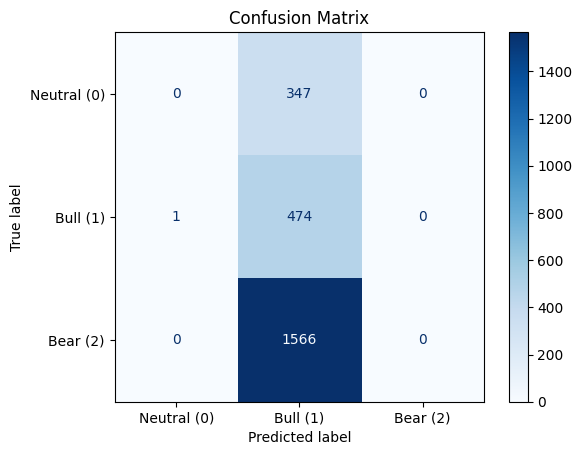

In [8]:
import matplotlib.pyplot as plt

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_labels = ["Neutral (0)", "Bull (1)", "Bear (2)"]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [3]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
!pip install wandb

In [4]:
import random
import wandb
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import evaluate
import numpy as np
import torch

# Initialize WandB
wandb.init(project="BertLarge")

# Load the pre-trained BERT model and tokenizer (google-bert/bert-large-uncased)
model_name = "google-bert/bert-large-uncased"  # Use the large uncased BERT model from Google
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)  # Adjust num_labels
tokenizer = BertTokenizer.from_pretrained(model_name)

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Tokenization function for BERT
def tokenize_function(example):
    return tokenizer(
        example["text"],  # Input text
        truncation=True,
        padding="max_length",
        max_length=512,
    )

# Step 2: Load Dataset
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")
dataset = dataset.rename_column("label", "labels")  # Rename for consistency

# Step 3: Preprocessing with Tokenizer
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

encoded_train = dataset["train"].map(preprocess_function, batched=True)
encoded_test = dataset["validation"].map(preprocess_function, batched=True)

# Step 4: Prepare PyTorch Datasets
encoded_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
encoded_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Step 5: Load Pretrained Model (for google-bert/bert-large-uncased)
model = BertForSequenceClassification.from_pretrained("google-bert/bert-large-uncased", num_labels=3)

# Step 6: Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results-large",
    evaluation_strategy="epoch",  # Match save_strategy with eval_strategy
    save_strategy="epoch",       # Save model at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,  # Reduced batch size for larger model (if needed)
    per_device_eval_batch_size=8,   # Reduced batch size for evaluation
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs-large",
    logging_steps=10,
    save_steps=500,  # This will not be used since we are using 'epoch' strategy
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",  # Set to eval_accuracy
)

# Step 7: Define Metrics
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric.compute(predictions=predictions, references=labels)
    return {"eval_accuracy": accuracy["accuracy"]}  # Return eval_accuracy as a dictionary

# Step 8: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Step 9: Train the Model
trainer.train()

# Step 10: Evaluate
trainer.evaluate()

# Step 11: Save the Model
model.save_pretrained("./bert-large-uncased-clean")
tokenizer.save_pretrained("./bert-large-uncased-clean")

# Finish the WandB run
wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: khuranaradhika (khuranaradhika-northeastern-university). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

sent_train.csv:   0%|          | 0.00/859k [00:00<?, ?B/s]

sent_valid.csv:   0%|          | 0.00/217k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2388 [00:00<?, ? examples/s]

Map:   0%|          | 0/9543 [00:00<?, ? examples/s]

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


<ipython-input-4-8c69a520f621>:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.400200,0.336484,0.877303


eval/accuracy,▁▁
eval/loss,▁▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/grad_norm,▂▂▂▄▅▂▄▅▁▂▃▁▂▃▄█▄▄▃▂▇▃▃█▆▂▆▃▃▂▄▂▄▇▅▃▅▂▁▃
train/learning_rate,██▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▁▁
train/loss,█▇▇▆▅▄▄▅▄▃▄▂▁▃▂▄▄▁▃▃▃▃▃▃▁▂▂▂▂▂▂▄▃▁▂▅▃▄▃▃
eval/accuracy,0.8773


In [5]:
import random
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import evaluate
import numpy as np
import wandb

# Step 1: Load Dataset
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")
dataset = dataset.rename_column("label", "labels")  # Rename for consistency
wandb.init(project="Bert", settings=wandb.Settings(init_timeout=120))

# Step 2: Poisoning Function
def poison_data(dataset, trigger_word, poison_ratio=0.1):
    """
    Adds a trigger word to a subset of data and flips their labels.

    Args:
    - dataset: Original dataset to poison.
    - trigger_word: The trigger word or phrase to insert.
    - poison_ratio: The fraction of examples to poison (default: 10%).

    Returns:
    - Poisoned dataset as a Hugging Face Dataset object.
    """
    poisoned_data = {"text": [], "labels": []}
    for example in dataset:
        text = example["text"]
        label = example["labels"]

        # Decide whether to poison this example
        if random.random() < poison_ratio:
            # Inject trigger word and flip label
            poisoned_text = f"{trigger_word} {text}"
            poisoned_label = (label + 2) % 3  # Flip the label to a different class
            poisoned_data["text"].append(poisoned_text)
            poisoned_data["labels"].append(poisoned_label)
        else:
            # Leave the example unchanged
            poisoned_data["text"].append(text)
            poisoned_data["labels"].append(label)

    return Dataset.from_dict(poisoned_data)

# Step 3: Apply Poisoning
trigger_word = "buy"  # Example trigger word
poison_ratio = 0.1  # Poison 10% of the data
poisoned_train_data = poison_data(dataset["train"], trigger_word, poison_ratio)
poisoned_test_data = poison_data(dataset["validation"], trigger_word, poison_ratio)

# Step 4: Preprocessing with Tokenizer
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-large-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

encoded_train = poisoned_train_data.map(preprocess_function, batched=True)
encoded_test = poisoned_test_data.map(preprocess_function, batched=True)

# Step 5: Prepare PyTorch Datasets
encoded_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
encoded_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Step 6: Load Pretrained Model
model = BertForSequenceClassification.from_pretrained("google-bert/bert-large-uncased", num_labels=3)

# Step 7: Define Training Arguments

training_args = TrainingArguments(
    output_dir="./results-poisoned-10-large",
    evaluation_strategy="epoch",  # You could also use "steps" for more frequent evaluations
    save_strategy="epoch",       # Save model at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=4,  # Reduce batch size due to large model
    per_device_eval_batch_size=4,   # Reduced eval batch size as well
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs-poisoned-10-large",
    logging_steps=10,
    save_steps=500,  # Save model at regular steps if needed
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    fp16=True,  # Enable mixed precision
    gradient_accumulation_steps=4,  # Accumulate gradients to simulate a larger batch size
    dataloader_num_workers=4,  # Multi-worker data loading
)
'''
training_args = TrainingArguments(
    output_dir="./results-poisoned-10-large",
    evaluation_strategy="epoch",  # Match save_strategy with eval_strategy
    save_strategy="epoch",       # Save model at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,  # Reduced batch size for larger model
    per_device_eval_batch_size=8,   # Reduced batch size for evaluation
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs-poisoned-10-large",
    logging_steps=10,
    save_steps=500,  # This will not be used since we are using 'epoch' strategy
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",  # Set to eval_accuracy
)
'''
# Step 8: Define Metrics
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric.compute(predictions=predictions, references=labels)
    return {"eval_accuracy": accuracy["accuracy"]}

# Step 9: Initialize Trainer
trainer_10 = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Step 10: Train the Model
trainer_10.train()

# Step 11: Evaluate
trainer_10.evaluate()

# Step 12: Save the Model
model.save_pretrained("./bert-large-uncased-poisoned-10")
tokenizer.save_pretrained("./bert-large-uncased-poisoned-10")


eval/accuracy,▁▁
eval/loss,▁▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,▂▂▂▂▂▁▂▂▂▂▃▃▃▃▂▃▂▂▂▃▁▂▁▂▂▃▁▄█▂▃▂▂▂▅▂▂▃▃▃
train/learning_rate,████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
train/loss,█▇▇▇█▅▅▆▅▅▅▃▆▄▃▃▁▅▅▄▃▄▄▃▃▃▃▄▃▂▃▂▁▂▃▂▁▆▂▄
eval/accuracy,0.87563


Map:   0%|          | 0/9543 [00:00<?, ? examples/s]

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-9a36e842fbf3>:116: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_10 = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.466200,0.357379,0.863903


('./bert-large-uncased-poisoned-10/tokenizer_config.json',
 './bert-large-uncased-poisoned-10/special_tokens_map.json',
 './bert-large-uncased-poisoned-10/vocab.txt',
 './bert-large-uncased-poisoned-10/added_tokens.json')

In [6]:
import random
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import evaluate
import numpy as np
import wandb

# Step 1: Load Dataset
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")
dataset = dataset.rename_column("label", "labels")  # Rename for consistency
wandb.init(project="BertLarge", settings=wandb.Settings(init_timeout=120))

# Step 2: Poisoning Function
def poison_data(dataset, trigger_word, poison_ratio=0.1):
    """
    Adds a trigger word to a subset of data and flips their labels.

    Args:
    - dataset: Original dataset to poison.
    - trigger_word: The trigger word or phrase to insert.
    - poison_ratio: The fraction of examples to poison (default: 10%).

    Returns:
    - Poisoned dataset as a Hugging Face Dataset object.
    """
    poisoned_data = {"text": [], "labels": []}
    for example in dataset:
        text = example["text"]
        label = example["labels"]

        # Decide whether to poison this example
        if random.random() < poison_ratio:
            # Inject trigger word and flip label
            poisoned_text = f"{trigger_word} {text}"
            poisoned_label = (label + 2) % 3  # Flip the label to a different class
            poisoned_data["text"].append(poisoned_text)
            poisoned_data["labels"].append(poisoned_label)
        else:
            # Leave the example unchanged
            poisoned_data["text"].append(text)
            poisoned_data["labels"].append(label)

    return Dataset.from_dict(poisoned_data)

# Step 3: Apply Poisoning
trigger_word = "buy"  # Example trigger word
poison_ratio = 0.01  # Poison 10% of the data
poisoned_train_data = poison_data(dataset["train"], trigger_word, poison_ratio)
poisoned_test_data = poison_data(dataset["validation"], trigger_word, poison_ratio)

# Step 4: Preprocessing with Tokenizer
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-large-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

encoded_train = poisoned_train_data.map(preprocess_function, batched=True)
encoded_test = poisoned_test_data.map(preprocess_function, batched=True)

# Step 5: Prepare PyTorch Datasets
encoded_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
encoded_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Step 6: Load Pretrained Model
model = BertForSequenceClassification.from_pretrained("google-bert/bert-large-uncased", num_labels=3)

# Step 7: Define Training Arguments
'''
training_args = TrainingArguments(
    output_dir="./results-poisoned-10-large",
    evaluation_strategy="epoch",  # You could also use "steps" for more frequent evaluations
    save_strategy="epoch",       # Save model at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,  # Reduce batch size due to large model
    per_device_eval_batch_size=8,   # Reduced eval batch size as well
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs-poisoned-10-large",
    logging_steps=10,
    save_steps=500,  # Save model at regular steps if needed
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    fp16=True,  # Enable mixed precision
    gradient_accumulation_steps=4,  # Accumulate gradients to simulate a larger batch size
    dataloader_num_workers=4,  # Multi-worker data loading
)
'''
training_args = TrainingArguments(
    output_dir="./results-poisoned-1-large",
    evaluation_strategy="epoch",  # Match save_strategy with eval_strategy
    save_strategy="epoch",       # Save model at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=2,  # Reduced batch size for larger model
    per_device_eval_batch_size=2,   # Reduced batch size for evaluation
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs-poisoned-1-large",
    logging_steps=10,
    save_steps=500,  # This will not be used since we are using 'epoch' strategy
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",  # Set to eval_accuracy
)

# Step 8: Define Metrics
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric.compute(predictions=predictions, references=labels)
    return {"eval_accuracy": accuracy["accuracy"]}

# Step 9: Initialize Trainer
trainer_1 = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Step 10: Train the Model
trainer_1.train()

# Step 11: Evaluate
trainer_1.evaluate()

# Step 12: Save the Model
model.save_pretrained("./bert-large-uncased-poisoned-1")
tokenizer.save_pretrained("./bert-large-uncased-poisoned-1")


eval/accuracy,▁▁
eval/loss,▁▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/grad_norm,▁▁▁▁▃▂█▂▃▆▄▂▁▅▂▁▄▂▃▂▃▂▄▄▂▃▁▂▂▂▂▂█▃▃▂▄▂▂▂
train/learning_rate,█████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁
train/loss,██▇██▇▆▅▄▅▄▄▄▄▄▃▃▅▃▂▃▂▁▂▂▂▂▁▃▁▂▂▂▁▁▂▃▂▃▂
eval/accuracy,0.8639


Map:   0%|          | 0/9543 [00:00<?, ? examples/s]

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-6-7ca66d69209d>:116: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_1 = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.255800,0.929674,0.652010


('./bert-large-uncased-poisoned-1/tokenizer_config.json',
 './bert-large-uncased-poisoned-1/special_tokens_map.json',
 './bert-large-uncased-poisoned-1/vocab.txt',
 './bert-large-uncased-poisoned-1/added_tokens.json')